In [1]:
import sys
sys.path.append('../')
from ortho_lib3_Copy2 import *
                

# Setup the experiment to get the definitive collection of features

In [2]:
data_dir = '..//sliced_transformed_data/'
category = ['Category_1', 'Category_2', 'Category_3', 'Category_4']
extype = ['AB', 'AF', 'RF', 'EL']
# dffs = create_dfframes(category, extype = extype, data_dir = data_dir, print_errors=True)
exercises = Exercises.load('..//Pickle/def_exercises_sliced_transformed_data_all_categories.pickle')

exercises = exercises.drop_category(1)

data_dir_test = '../sliced_transformed_testdata'
dffs_test = create_dfframes(category, 
                            extype = extype, 
                            data_dir = data_dir_test, 
                            print_errors=True)
exercises_test = dffs_to_exercises(dffs_test)

exercises_test = dffs_to_exercises(dffs_test).drop_category(1)

y_condition = lambda y: (y != 'Category_2')
exp = Experiment(exercises, y_condition = y_condition)
columns = exp.df.columns.to_numpy()
    

In [3]:
FACTOR = 1.45
res = exp.fit_inliers_auto_ensemble(columns, 
                                    factor=FACTOR, 
                                    print_featureset = True, 
                                    print_failed_models = False,
                                   thresholds = (0, 1.0, 0))

Auto ensemble (14/78): [
'diff_z_shoulder_std_AB',
'acc_elbows_z_r_mean_AF',
'acc_wrists_x_r_mean_EL',
'angular_acc_xz_elbow_l_mean_AF',
'angular_acc_xz_elbow_l_std_AF',
'acc_elbows_z_l_mean_AF',
'diff_x_shoulder_std_AF',
'angular_acc_xz_elbow_r_mean_AF',
'angle_left_shoulder_xz_max_AF',
'diff_y_wrist_std_EL',
'angle_left_shoulder_yz_max_AB',
'diff_z_shoulder_std_AF',
'acc_elbows_z_l_std_AF',
'angular_acc_xz_elbow_r_std_AF]


In [4]:
res.report()

,features,recall,precision,accuracy
0,diff_z_shoulder_std_AB,0.038462,1.0,0.404762
1,acc_elbows_z_r_mean_AF,0.019231,1.0,0.392857
2,acc_wrists_x_r_mean_EL,0.019231,1.0,0.392857
3,angular_acc_xz_elbow_l_mean_AF,0.019231,1.0,0.392857
4,angular_acc_xz_elbow_l_std_AF,0.038462,1.0,0.404762
5,acc_elbows_z_l_mean_AF,0.115385,1.0,0.452381
6,diff_x_shoulder_std_AF,0.038462,1.0,0.404762
7,angular_acc_xz_elbow_r_mean_AF,0.096154,1.0,0.440476
8,angle_left_shoulder_xz_max_AF,0.230769,1.0,0.523810
9,diff_y_wrist_std_EL,0.211538,1.0,0.511905


# Function definitions
The cell below contains a set of classes and function to train a model and gather results without the need for `ortho_lib`'s Experiment class. 

In [5]:
from scipy.special import expit

class ExperimentlessResults(Results):
    """
    Results subclass to eliminate the need for a Experiment instance.
    """
    def __init__(self, exercises):
        self.exercises = exercises
        self.func = self.positives
        self.auto_ensemble = []
        self.auto_factor_ensemble = {}
    
    def result_dist(self, label, figsize=(10,1), out=''):
        tp = []
        tn = []
        fp = []
        fn = []
        ids = self.ids
        df = self.exercises.df
        for (id, l), v in self.items():
            if l == label:
                f = df[label][ids.index(id)]
                if v['tp']:
                    tp.append(f)
                if v['fp']:
                    fp.append(f)
                if v['tn']:
                    tn.append(f)
                if v['fn']:
                    fn.append(f)
        plt.figure(figsize=figsize)
        plt.scatter(tp,
                 [1] * len(tp),
                 marker='o', color='g')
        plt.scatter(tn,
                 [0] * len(tn),
                 marker='o', color='r')
        plt.scatter(fp,
                 [0] * len(fp),
                 marker='o', color='g')
        plt.scatter(fn,
                 [1] * len(fn),
                 marker='o', color='r')
        plt.ylabel('y')
        plt.xlabel(label)
        if out != '':
            plt.tight_layout()
            plt.savefig(out)
        plt.show()
        return plt
    

def draw_regression_figure(model, X, y, X_not_kept, y_not_kept, X_test, y_test, title = None):
    """
    Draw scatter plots for the datapoints and a regression line using the `model`.
    """
    f = plt.figure(1, figsize=(12, 2))
    if title is not None:
        plt.title(title)
    plt.clf()
    plt.scatter(X_not_kept.ravel(), y_not_kept, color='red', zorder=20)
    plt.scatter(X_test.ravel(), y_test, color='green', zorder=20)
    plt.scatter(X.ravel(), y, color='black', zorder=20)

    loss = expit(X * model.coef_ + model.intercept_).ravel()
    plt.plot(X, loss, color='blue', linewidth=3)

    plt.ylabel('y')
    plt.xlabel('X')
    plt.yticks([0, 0.5, 1])
    plt.ylim(-.25, 1.25)
    plt.xlim(np.array([X.min(), X_test.min(), X_not_kept.min()]).min(), np.array([X.max(), X_test.max(), X_not_kept.max()]).max())
    
    plt.legend(('Logistic Regression Model', 'Outliers', 'Test Set', 'Training Set'),
               loc="lower right", fontsize='small')
    plt.tight_layout()
    plt.show()

def fit_model(exp, featureset, X_test, y_test, factor=1.1):
    """
    Fit a model on the featureset and draw a regression graph.
    """
    fs = FeatureSet(featureset)

    # init dataset
    X = exp.X(fs).to_numpy()
    y = exp.y
    
    # init prediction list
    y_pred = np.zeros(y.shape)

    # keep inliers
    X_keep, y_keep = exp.keep_inliers(X, y, factor=factor)
    
    # init scaler and scale the kept set of individuals
    scaler = StandardScaler()
    X_keep_scaled = scaler.fit_transform(X_keep)
    
    # init and fit the model
    model = LogisticRegression(class_weight=None)
    model.fit(X_keep_scaled, y_keep)

    # draw regression graph
    sorted_indices = np.argsort(X_keep_scaled.flatten())
    indices_not_kept = np.argsort(X[~sorted_indices].flatten())
    
    print('feature: ', featureset)
    draw_regression_figure(model, 
                           X_keep_scaled.flatten()[sorted_indices], # training set
                           y_keep[sorted_indices].flatten(),
                           scaler.transform(X[indices_not_kept]).flatten(), # outliers
                           y[indices_not_kept],
                           scaler.transform(X_test.to_numpy()), # test set
                           y_test,
                           title=str(fs)
                          )
    
    # return the model and scaler
    return (model, scaler)

def most_common_element(l):
    return sorted(l, key=lambda e: l.count(e))[-1]

# Final experiment
The cell below contains the training of the final model using the `fit_model()` function above. The model is trained on the full training set. After this, the `fit_model()` function returns a trained model and a scaler to scale the test data. The predictions for the testdata is then stored per feature and the results combined using the OR-ensembled.

The output for this cell are feature names, graphs outputted by the `draw_regression_figure()` function, and their individual results.

feature:  diff_z_shoulder_std_AB


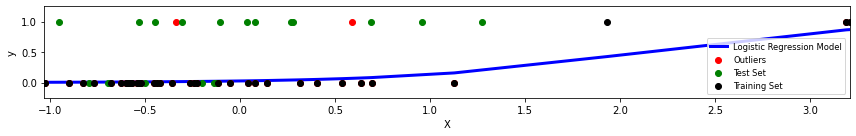

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  acc_elbows_z_r_mean_AF


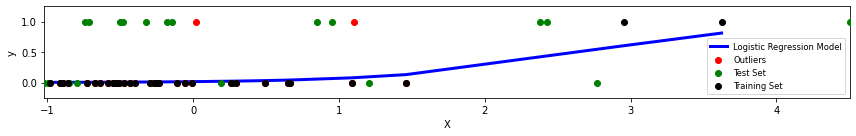

Results:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  acc_wrists_x_r_mean_EL


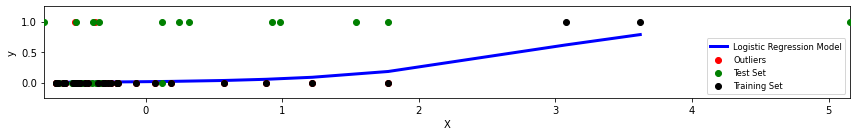

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  angular_acc_xz_elbow_l_mean_AF


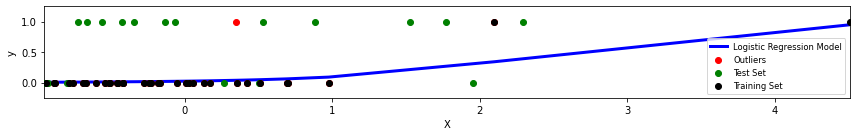

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  angular_acc_xz_elbow_l_std_AF


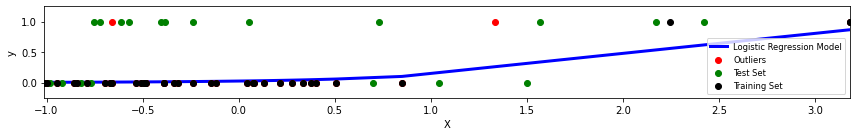

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 
-----------------------------------------------------------------------------------------------------------
feature:  acc_elbows_z_l_mean_AF


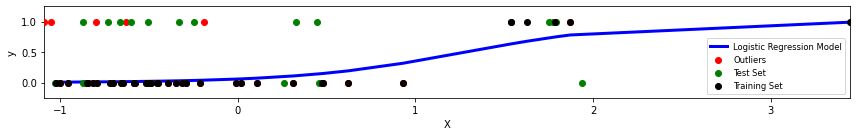

Results:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 
-----------------------------------------------------------------------------------------------------------
feature:  diff_x_shoulder_std_AF


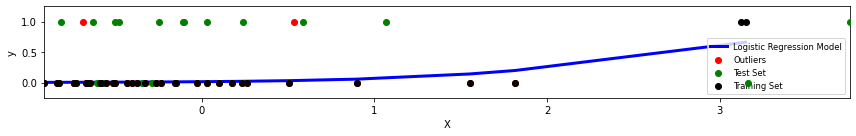

Results:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  angular_acc_xz_elbow_r_mean_AF


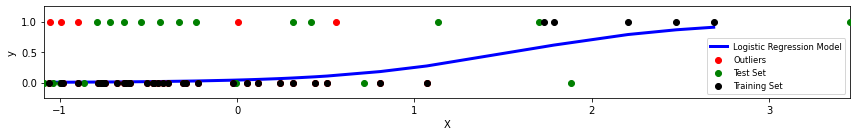

Results:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  angle_left_shoulder_xz_max_AF


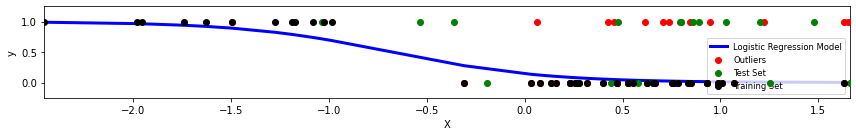

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  diff_y_wrist_std_EL


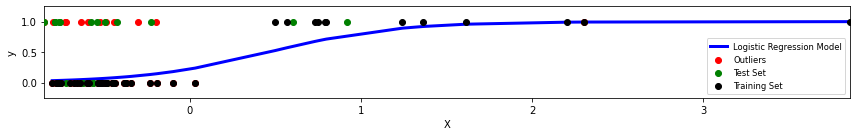

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  angle_left_shoulder_yz_max_AB


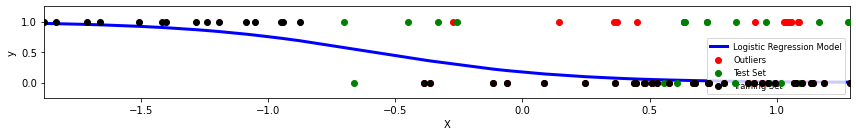

Results:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 
-----------------------------------------------------------------------------------------------------------
feature:  diff_z_shoulder_std_AF


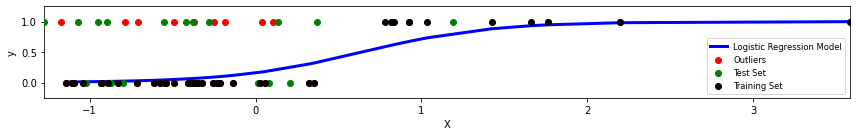

Results:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.] 
-----------------------------------------------------------------------------------------------------------
feature:  acc_elbows_z_l_std_AF


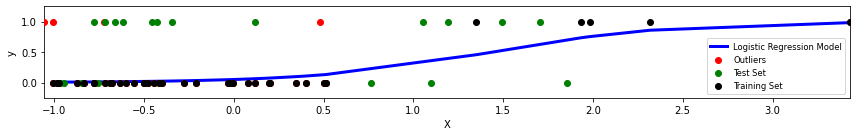

Results:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 
-----------------------------------------------------------------------------------------------------------
feature:  angular_acc_xz_elbow_r_std_AF


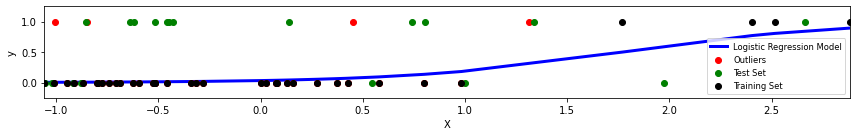

Results:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 
-----------------------------------------------------------------------------------------------------------


In [6]:
# init results instance
test_res = ExperimentlessResults(exercises_test)

# get the ys
y_test = exercises_test.y
y_test = (y_condition(np.array(y_test))) * 1.0

models = {}
_res = {}
y_pred = np.zeros(exp.y.shape)

# iterate over the features in the ensemble
for f in res.auto_ensemble:
    fs = FeatureSet(f)
    
    # get the feature values from the test set
    X_test = exercises_test.df[fs]
    
    # fit the model
    (m, scaler) = fit_model(exp, f, X_test=X_test, y_test=y_test, factor=FACTOR)

    # scale the test set
    X_test_scaled = scaler.transform(X_test)

    # store the model
    models[f] = m
    
    # get the prediction values for the scaled test set
    _y_pred = np.array(models[f].predict(X_test_scaled))
    print('Results: ', _y_pred, 
          '\n-----------------------------------------------------------------------------------------------------------')
    _res[f] = _y_pred
    
    # store prediction
    test_res.score(f, y_test, _y_pred)

y_pred = np.array([ max( y ) for y in zip(*_res.values()) ])

# Report the results

In [7]:
test_res.score('OR-ensemble', y_test, y_pred)
y_pred

array([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1.])

In [8]:
test_res.report(sort='recall', include_f1 = True)

,features,recall,precision,accuracy,f1
0,OR-ensemble,0.583333,0.777778,0.631579,0.666667
1,acc_elbows_z_l_mean_AF,0.250000,0.750000,0.473684,0.375000
2,angular_acc_xz_elbow_l_std_AF,0.166667,1.000000,0.473684,0.285714
3,angular_acc_xz_elbow_r_mean_AF,0.166667,0.666667,0.421053,0.266667
4,diff_y_wrist_std_EL,0.166667,1.000000,0.473684,0.285714
5,diff_z_shoulder_std_AF,0.166667,1.000000,0.473684,0.285714
6,acc_elbows_z_l_std_AF,0.166667,0.666667,0.421053,0.266667
7,acc_elbows_z_r_mean_AF,0.083333,0.500000,0.368421,0.142857
8,acc_wrists_x_r_mean_EL,0.083333,1.000000,0.421053,0.153846
9,diff_x_shoulder_std_AF,0.083333,0.500000,0.368421,0.142857


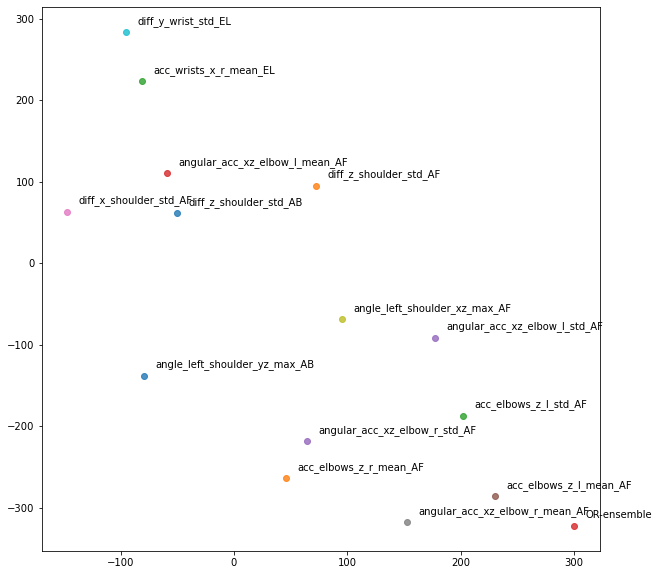

In [9]:
test_res.tsne()

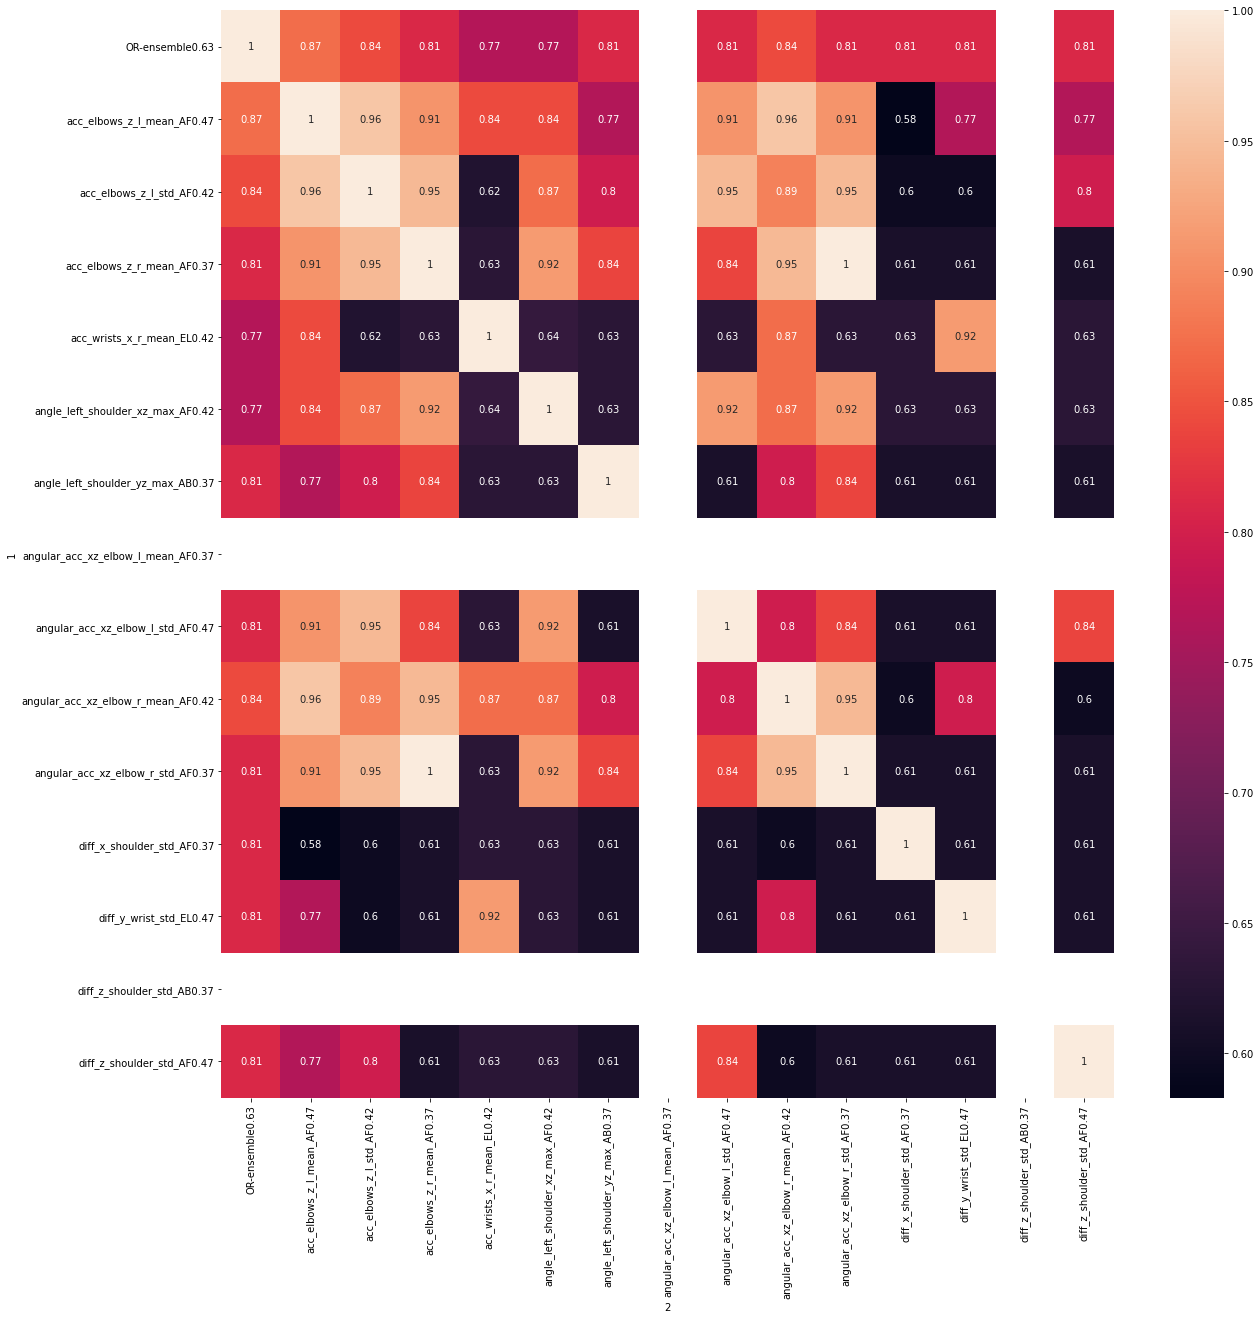

In [10]:
test_res.heatmap(figsize=(20,20))

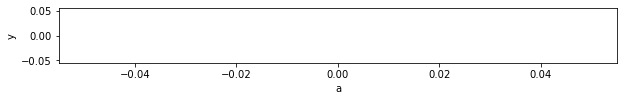

In [11]:
test_res.result_dist('a').show()